In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from sklearn import preprocessing

import os
import gc
import sys

In [2]:
d = pd.read_csv('peqw.csv')

In [4]:
d.rename(index=str, columns = {'Unnamed: 0':'time'}, inplace=True)

In [28]:
d.head()
d.shape

(420, 105)

In [6]:
bmom1m = [0 if i < 0 else 1 for i in d['mom1m']]

In [10]:
d['bmom1m'] = bmom1m

In [11]:
d.drop('mom1m', axis=1, inplace=True)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [15]:
scaler.fit(d.drop('bmom1m', axis=1))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
scaled_feat = scaler.transform(d.drop('bmom1m', axis=1))
d_feat = pd.DataFrame(scaled_feat, columns=list(d.columns).remove('bmom1m'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_feat,
                                                    d['bmom1m'],
                                                    test_size=0.30)

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

In [186]:
gbc = GradientBoostingClassifier(random_state=101, learning_rate=.04)
gbc.fit(X_train, y_train)
gp = gbc.predict(X_test)

In [187]:
print(classification_report(y_test, gp))
print(confusion_matrix(y_test, gp))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        85
           1       0.61      0.61      0.61        41

   micro avg       0.75      0.75      0.75       126
   macro avg       0.71      0.71      0.71       126
weighted avg       0.75      0.75      0.75       126

[[69 16]
 [16 25]]


In [307]:
t = 4
est = t * 10
est_rate = t

cons = [.01, .1]
over = [.001, 0.01, 0.02, 0.05, 0.075, 0.1, .15]

wide = list(range(est_rate, est, est_rate))
pres = list(range(1,est))

b_grid = {
    "learning_rate": cons, 
    "n_estimators": wide,
    "random_state" : [101]
}

In [308]:
from sklearn.model_selection import GridSearchCV
bgrid = GridSearchCV(GradientBoostingClassifier(),
                     b_grid,
                     refit=True,
                     verbose=3, 
                     n_jobs=36)

In [309]:
bgrid.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done   2 out of  54 | elapsed:    0.0s remaining:    1.1s
[Parallel(n_jobs=36)]: Done  21 out of  54 | elapsed:    0.2s remaining:    0.3s


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=36)]: Done  40 out of  54 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=36)]: Done  54 out of  54 | elapsed:    0.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'learning_rate': [0.01, 0.1], 'n_estimators': [4, 8, 12, 16, 20, 24, 28, 32, 36], 'random_state': [101]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [310]:
bgrid.best_params_

{'learning_rate': 0.1, 'n_estimators': 36, 'random_state': 101}

In [311]:
bgrid.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=36,
              n_iter_no_change=None, presort='auto', random_state=101,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [312]:
bgrid_predictions = bgrid.predict(X_test)
print(confusion_matrix(y_test,bgrid_predictions))
print(classification_report(y_test,bgrid_predictions))

[[72 13]
 [17 24]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        85
           1       0.65      0.59      0.62        41

   micro avg       0.76      0.76      0.76       126
   macro avg       0.73      0.72      0.72       126
weighted avg       0.76      0.76      0.76       126



In [313]:
pbgrid_predictions = bgrid.predict(X_train)
print(confusion_matrix(y_train, pbgrid_predictions))
print(classification_report(y_train, pbgrid_predictions))

[[195   0]
 [  3  96]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       195
           1       1.00      0.97      0.98        99

   micro avg       0.99      0.99      0.99       294
   macro avg       0.99      0.98      0.99       294
weighted avg       0.99      0.99      0.99       294



In [250]:
from sklearn.neighbors import KNeighborsClassifier

In [358]:
error_rate = []
rer = []
jn = 50

# Will take some time
for i in range(1,jn):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    rate = np.mean(pred_i != y_test)
    error_rate.append(rate)
    rer.append((i, rate))

(17, 0.23809523809523808)
(33, 0.23809523809523808)
(35, 0.23809523809523808)
(15, 0.24603174603174602)
(21, 0.24603174603174602)
(23, 0.24603174603174602)
(30, 0.24603174603174602)
(31, 0.24603174603174602)
(32, 0.24603174603174602)
(34, 0.24603174603174602)


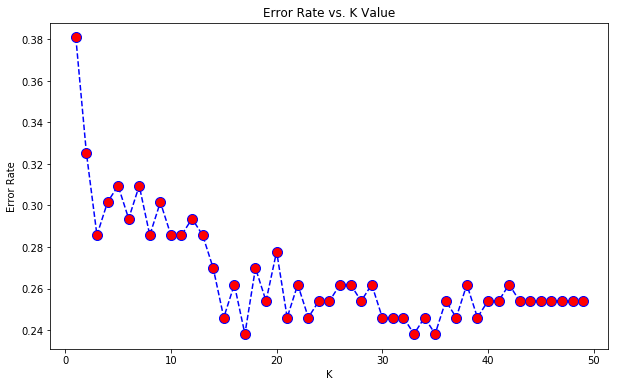

In [359]:
plt.figure(figsize=(10,6))
plt.plot(range(1,jn),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

for i in sorted(rer, key=lambda x: x[1])[:10]:
    print(i)

In [360]:
nn = 15

knn = KNeighborsClassifier(n_neighbors=nn)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=', nn)
print('\n')
print(confusion_matrix(y_test,pred))
print(confusion_matrix(y_test,pred)[0][1] + 
      confusion_matrix(y_test,pred)[1][0])
print('\n')
print(classification_report(y_test,pred))

WITH K= 15


[[75 10]
 [21 20]]
31


              precision    recall  f1-score   support

           0       0.78      0.88      0.83        85
           1       0.67      0.49      0.56        41

   micro avg       0.75      0.75      0.75       126
   macro avg       0.72      0.69      0.70       126
weighted avg       0.74      0.75      0.74       126



In [361]:
ogrid_predictions = knn.predict(X_train)
print(confusion_matrix(y_train, ogrid_predictions))
print(confusion_matrix(y_train, ogrid_predictions)[0][1] + 
      confusion_matrix(y_train, ogrid_predictions)[1][0])
print(classification_report(y_train, ogrid_predictions))

[[180  15]
 [ 49  50]]
64
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       195
           1       0.77      0.51      0.61        99

   micro avg       0.78      0.78      0.78       294
   macro avg       0.78      0.71      0.73       294
weighted avg       0.78      0.78      0.77       294



In [362]:
oere = []
orer = []

# Will take some time
for i in range(1,jn):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_train)
    rate = np.mean(pred_i != y_train)
    oere.append(rate)
    orer.append((i, rate))

[(1, 0.0), (2, 0.1598639455782313), (3, 0.1598639455782313), (4, 0.20068027210884354), (7, 0.20408163265306123)]


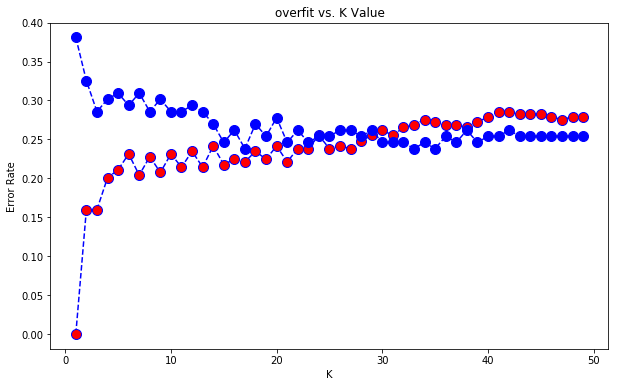

In [363]:
plt.figure(figsize=(10,6))
plt.plot(range(1,jn), oere, color='blue', linestyle='dashed', 
         marker='o',
         markerfacecolor='red', markersize=10)
plt.plot(range(1,jn),error_rate,color='blue', linestyle='dashed', 
         marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('overfit vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

print(sorted(orer, key=lambda x: x[1])[:5])

In [248]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
rs = 0

In [65]:
error_rate = []
rer = []
est = 300

for i in range(1,est):
    rfc = RandomForestClassifier(n_estimators=i, random_state=rs)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    rate = np.mean(pred_i != y_test)
    error_rate.append(rate)
    rer.append((i, rate))

[(30, 0.25396825396825395), (28, 0.2619047619047619), (68, 0.2619047619047619), (24, 0.2698412698412698), (26, 0.2698412698412698)]


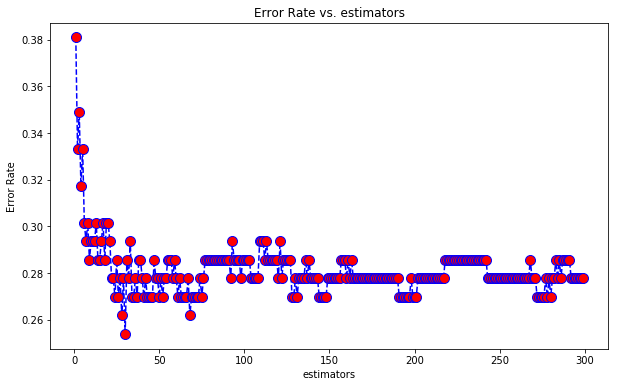

In [66]:
plt.figure(figsize=(10,6))
plt.plot(range(1,est),error_rate,color='blue', 
         linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. estimators')
plt.xlabel('estimators')
plt.ylabel('Error Rate')

print(sorted(rer, key=lambda x: x[1])[:5])

In [365]:
rfc = RandomForestClassifier(n_estimators=30, random_state=rs)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[72 13]
 [22 19]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.80        85
           1       0.59      0.46      0.52        41

   micro avg       0.72      0.72      0.72       126
   macro avg       0.68      0.66      0.66       126
weighted avg       0.71      0.72      0.71       126



In [75]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [78]:
svc_pred = model.predict(X_test)

In [79]:
print(confusion_matrix(y_test,svc_pred))
print(classification_report(y_test,svc_pred))

[[70  9]
 [27 20]]
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        79
           1       0.69      0.43      0.53        47

   micro avg       0.71      0.71      0.71       126
   macro avg       0.71      0.66      0.66       126
weighted avg       0.71      0.71      0.70       126



In [106]:
param_grid = {'C': [.01, 0.1, 1, 10, 100, 1000, 10000], 
              'gamma': [.1, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear', 'poly'], 
              'degree': [0, 1, 2, 3, 4, 5, 6, 7, 8]}

In [175]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3, n_jobs=12)

In [176]:
grid.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1134 candidates, totalling 3402 fits


[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 337 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 2257 tasks      | elapsed:    5.8s
[Parallel(n_jobs=12)]: Done 3402 out of 3402 | elapsed:    8.9s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [0.1, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'linear', 'poly'], 'degree': [0, 1, 2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [177]:
grid.best_params_

{'C': 1, 'degree': 0, 'gamma': 0.01, 'kernel': 'rbf'}

In [178]:
grid.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=0, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [179]:
grid_pred = grid.predict(X_test)
print(confusion_matrix(y_test,grid_pred))
print(classification_report(y_test,grid_pred))

[[76  9]
 [24 17]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        85
           1       0.65      0.41      0.51        41

   micro avg       0.74      0.74      0.74       126
   macro avg       0.71      0.65      0.66       126
weighted avg       0.73      0.74      0.72       126

